In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, time, shutil
from PIL import Image
import csv
import cv2

import signal


path="C:\\Users\\ЛФКИТ-3\\Documents\\Interferom\\img\\seq\\"
from IPython.display import clear_output
from IPython import display

%matplotlib inline

In [2]:
#shutil.rmtree(path)
#os.makedirs(path)
caps = [cv2.VideoCapture(i) for i in [1] ]
# Set exposition time-------
for cap in caps:
    cap.set(15, 0.1)
# 
retry_sec = 0.5
retry_cnt = 5

def gen_int_handler(caps):
    def int_handler(signum, frame):
        print("Got sigterm, releasing cameras")
        for cap in caps:
            cap.release()
        raise  Exception('Interrupt') 
        #cv2.destroyAllWindows()
    return int_handler


def upd_plot(new_seq=[]):
    display.clear_output(wait=True)
    plt.plot(new_seq)
    display.display(plt.show())

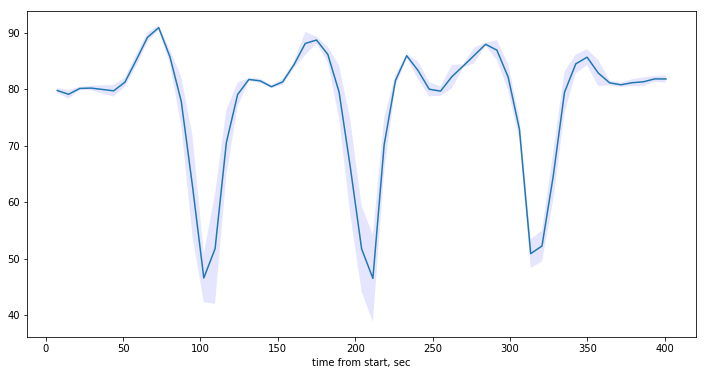

None

7.299281120300293
read from 0 cam
read from 0 cam
read from 0 cam
read from 0 cam
read from 0 cam
read from 0 cam
Got sigterm, releasing cameras


Exception: Interrupt

In [3]:
files = []
intens = []
stddevs=[]
times=[]
start =time.time()
cam_shot_interval = 0.2
mean_over_shots = 50
display_time = 30
time_ = 0.0
signal.signal(signal.SIGINT, gen_int_handler(caps))

while True:
    iter_start = time.time()
    ins = []
    cam_idx=0
    num = 0
    for shot in range(mean_over_shots):
        for cap in caps:
            tries=0
            img, ret = None, False
            while True:
                ret, img = cap.read()
                if not ret:
                    tries+=1
                    print("Camera %i returned None %i times. retry in %f seconds"%(cam_idx,tries,retry_sec))
                    if (tries==retry_cnt):
                        print("Camera %i is not working. Giving up."%num)
                        print()
                        break
                    time.sleep(retry_sec)
                else:
                    # cv2.imshow("camera%i"%num, img)
                    print("read from %i cam"%num)
                    # Sucessfully read, go for next cam
                    ins.append(np.mean(img))
                    break
            cam_idx +=1

    #clear_output()
    ints = np.mean(ins)
    sdev = np.std(ins)
    if not np.isnan(ints):
        intens.append(ints)
        stddevs.append(sdev)
        times.append(time.time()-start)

    points_num = int(display_time//cam_shot_interval)
    display_obj = (np.array(intens[-points_num:]),
                   np.array(stddevs[-points_num:]))
    
    print('got %i new pictures. Intensity: %f, stddev %f'%
          (len(ins), ints, sdev )) 
    display.clear_output(wait=True)
    f,ax = plt.subplots(figsize=(12,6))
    # plot intensities
    ax.plot(times[-points_num:],display_obj[0])
    # plot standart deviation
    ax.fill_between(times[-points_num:], display_obj[0]+display_obj[1],
                     display_obj[0]-display_obj[1], facecolor='blue', alpha=0.1)
    plt.xlabel('time from start, sec')

    display.display(plt.show())
    time.sleep(cam_shot_interval)
    print(time.time()- iter_start)


In [4]:
# SAVING TO FILE
save_to="C:\\Users\\ЛФКИТ-3\\Documents\\Interferom\\data\\"+\
        "data_%s_port2.csv"%time.strftime('%d-%m-%Y_%H-%M')

print('total number of points: %i'%len(intens))
result = np.array(intens)
## times = np.arange(0,len(intens),file_check_interval)
data = np.stack((result,times)).T
print(data.shape)
np.savetxt(save_to,data,delimiter=',',fmt='%10.5f')
print ("saved to %s"%save_to)

total number of points: 55
(55, 2)
saved to C:\Users\ЛФКИТ-3\Documents\Interferom\data\data_05-07-2018_20-20_port2.csv


In [ ]:
time.strftime('-%x-%H:%M')


In [ ]:
np.isnan(intens[0])